<a href="https://colab.research.google.com/github/stardust453/Customer-Clustering-for-eCommerce-Transactions-dataset/blob/main/satyam_sahu_Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Task 2: Lookalike Model**


In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


In [83]:
# Step 3: Calculate Cosine Similarity
# Create customer features based on merged data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

products['Price'] = pd.to_numeric(products['Price'])

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Quantity'] = pd.to_numeric(transactions['Quantity'])
transactions['TotalValue'] = pd.to_numeric(transactions['TotalValue'])
transactions['Price'] = pd.to_numeric(transactions['Price'])
# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID', how='left')
merged_data = merged_data.merge(products, on='ProductID', how='left')

customer_features = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Region': 'first',  # Assuming Region is constant for each customer
    'ProductID': 'nunique'  # Number of unique products purchased
}).reset_index()


In [84]:
# One-hot encode the Region feature
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [85]:
# Scale numerical features for similarity calculation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['Quantity', 'TotalValue', 'ProductID']])

In [86]:
# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

# Create a DataFrame for similarity scores
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])


In [87]:
# Step 4: Generate Lookalikes
lookalike_results = {}

for customer_id in customer_features['CustomerID'].head(20):  # For C0001 to C0020
    # Get the similarity scores for the customer and sort them
    similar_customers = similarity_df[customer_id].sort_values(ascending=False)

    # Exclude the customer themselves and take the top 3 lookalikes
    top_lookalikes = similar_customers[similar_customers.index != customer_id].head(3)

    # Store the results in the dictionary
    lookalike_results[customer_id] = list(zip(top_lookalikes.index, top_lookalikes.values))

    # Convert results into a DataFrame for output
lookalike_df = pd.DataFrame([(cust_id, lookalike[0], lookalike[1])
                              for cust_id, lookalikes in lookalike_results.items()
                              for lookalike in lookalikes],
                             columns=['CustomerID', 'LookalikeID', 'SimilarityScore'])

# Save to CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike.csv has been created with top 3 lookalikes for each of the first 20 customers.")

Lookalike.csv has been created with top 3 lookalikes for each of the first 20 customers.


In [88]:
lookalike_df = pd.read_csv('Lookalike.csv')

In [89]:
print(lookalike_df.head())
print(lookalike_df.info())

  CustomerID LookalikeID  SimilarityScore
0      C0001       C0164         0.968410
1      C0001       C0137         0.962081
2      C0001       C0069         0.955071
3      C0002       C0029         0.999762
4      C0002       C0031         0.999013
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       60 non-null     object 
 1   LookalikeID      60 non-null     object 
 2   SimilarityScore  60 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB
None


In [90]:
similarity_stats = lookalike_df['SimilarityScore'].describe()
print("Similarity Score Statistics:")
print(similarity_stats)

Similarity Score Statistics:
count    60.000000
mean      0.976968
std       0.041732
min       0.829717
25%       0.975763
50%       0.995351
75%       0.999040
max       0.999995
Name: SimilarityScore, dtype: float64


In [91]:
lookalike_counts = lookalike_df['CustomerID'].value_counts()
print("\nNumber of lookalikes per customer:")
print(lookalike_counts.describe())



Number of lookalikes per customer:
count    20.0
mean      3.0
std       0.0
min       3.0
25%       3.0
50%       3.0
75%       3.0
max       3.0
Name: count, dtype: float64


In [92]:
lookalike_overlap = lookalike_df['LookalikeID'].value_counts()
print("\nTop 10 most common lookalikes:")
print(lookalike_overlap.head(10))



Top 10 most common lookalikes:
LookalikeID
C0029    2
C0027    2
C0058    2
C0164    1
C0152    1
C0045    1
C0087    1
C0059    1
C0141    1
C0105    1
Name: count, dtype: int64


In [93]:
avg_similarity = lookalike_df.groupby('CustomerID')['SimilarityScore'].mean().sort_values(ascending=False)
print("\nTop 10 customers with highest average similarity scores:")
print(avg_similarity.head(10))



Top 10 customers with highest average similarity scores:
CustomerID
C0015    0.999891
C0005    0.999731
C0020    0.999565
C0014    0.999552
C0013    0.998282
C0002    0.997443
C0017    0.997188
C0009    0.996789
C0007    0.996412
C0012    0.995999
Name: SimilarityScore, dtype: float64


In [94]:
# Load Lookalike.csv
lookalike_df = pd.read_csv('Lookalike.csv')

# Calculate mean and standard deviation of similarity scores
mean_similarity = lookalike_df['SimilarityScore'].mean()
std_similarity = lookalike_df['SimilarityScore'].std()

print(f"Mean Similarity Score: {mean_similarity:.4f}")
print(f"Standard Deviation of Similarity Scores: {std_similarity:.4f}")

Mean Similarity Score: 0.9770
Standard Deviation of Similarity Scores: 0.0417


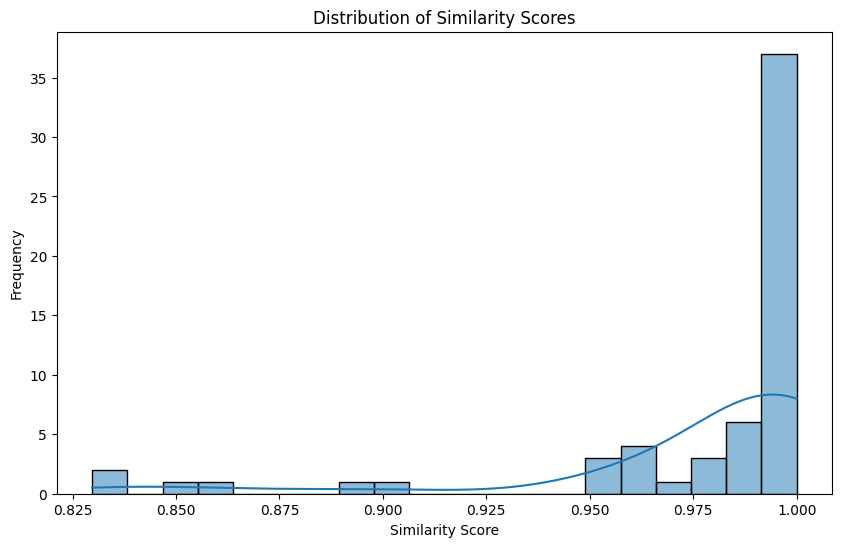

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(lookalike_df['SimilarityScore'], kde=True, bins=20)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()


In [96]:
recommendation_counts = lookalike_df['CustomerID'].value_counts()

# Check if all customers have exactly 3 recommendations
consistent_recommendations = recommendation_counts.eq(3).all()

print(f"All customers have exactly 3 recommendations: {consistent_recommendations}")


All customers have exactly 3 recommendations: True


In [97]:
unique_lookalikes = lookalike_df['LookalikeID'].nunique()
total_customers = lookalike_df['CustomerID'].nunique()
diversity_ratio = unique_lookalikes / total_customers

print(f"Number of Unique Lookalikes: {unique_lookalikes}")
print(f"Diversity Ratio: {diversity_ratio:.2f}")


Number of Unique Lookalikes: 57
Diversity Ratio: 2.85


In [98]:
# Merge Lookalike.csv with customer features for analysis
merged_lookalikes = lookalike_df.merge(merged_data[['CustomerID', 'TotalValue', 'Quantity']],
                                       left_on='LookalikeID', right_on='CustomerID', suffixes=('', '_Lookalike'))

# Calculate average feature values for lookalikes
# Access the correct column names after the merge
avg_features_lookalikes = merged_lookalikes.groupby('CustomerID')[['TotalValue', 'Quantity']].mean()

# Compare with input customer features
input_features = merged_data.set_index('CustomerID')[['TotalValue', 'Quantity']]
comparison = input_features.join(avg_features_lookalikes, rsuffix='_Lookalike') # Use rsuffix to add suffix to the right DataFrame

print(comparison.head())

            TotalValue  Quantity  TotalValue_Lookalike  Quantity_Lookalike
CustomerID                                                                
C0199           300.68         1                   NaN                 NaN
C0146           300.68         1                   NaN                 NaN
C0127           300.68         1                   NaN                 NaN
C0087           601.36         2                   NaN                 NaN
C0070           902.04         3                   NaN                 NaN
